# Assignment 1


In [ ]:
username = 'hinton024'
repo = 'reddit-sentiment-analysis'
!git clone https://github.com/{username}/{repo}
%cd {repo}
# https://github.com/hinton024/reddit-sentiment-analysis

Cloning into 'reddit-sentiment-analysis'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 275 (delta 2), reused 6 (delta 1), pack-reused 268 (from 1)
Receiving objects: 100% (275/275), 23.85 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (114/114), done.
/content/reddit-sentiment-analysis


In [ ]:
pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 1
%aimport redditClient

# Importing Necessary Libraries

In [ ]:
# Importing packages and nltk data libraries
import string
import json
import codecs
import re
import sys
from collections import Counter
from spellchecker import SpellChecker
import functools
import datetime
import time
import math
import os
import ijson

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download("wordnet")


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat

import pyLDAvis
import pyLDAvis.lda_model

from colorama import Fore, Back, Style
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Importing Reddit client and PRAW
from redditClient import redditClient
import praw
from prawcore.exceptions import TooManyRequests

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# subreddit name we interested in getting the hot submissions
sSubredditName = 'NVDA_Stock'
# maximum number of hot submissions
hotLimit = 5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Construct Reddit client then print our name to test.

In [ ]:
# construct Reddit client
client = redditClient()

# sanity check, you should see your own username printed out
print(client.user.me())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Comprehensive-End522


### Scrape reddit data through api and save it to json file

In [ ]:
@functools.lru_cache(maxsize=None)
def reddit_api_response(sSubredditName, hotLimit,start_date, end_date):
    # specify which subreddit we are interested in
    subreddit = client.subreddit(sSubredditName)
    # Convert dates to timestamps
    start_timestamp = int(start_date.timestamp())
    end_timestamp = int(end_date.timestamp())
    data = []; comments_json = []
    for submission in subreddit.top(limit=None):
        try:
            submission.comments.replace_more(limit=None) # expand all the comments
            if start_timestamp <= submission.created_utc <= end_timestamp:
                comments=[]
                for comment in submission.comments.list():
                    comment_data={
                        "author": comment.author.name if comment.author else "No Author",
                        "created": comment.created_utc,
                        "text": comment.body
                    }
                    comments.append(comment_data)
                post_data = {
                "title": submission.title,
                "author": submission.author.name if submission.author else "No Author",
                "score": submission.score,
                "created":submission.created_utc
                }
                data.append(post_data)
                comments_json.extend(comments)
            # else:
            #     break
        except TooManyRequests as e:
            time.sleep(60)
    print(data)
    comments_json = {"submissions":comments_json}
    final_data = {"submissions":data}
    with open(f"nvidia_stock_data_{start_date.strftime('%Y_%m_%d')}_{end_date.strftime('%Y_%m_%d')}.json", "w") as json_file:
        json.dump(final_data, json_file)
    with open(f"nvidia_stock_data_comments{start_date.strftime('%Y_%m_%d')}_{end_date.strftime('%Y_%m_%d')}.json", "w") as json_file:
        json.dump(comments_json, json_file)
    print("Comments Data saved to nvidia_stock_data_comments.json")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Run the above function to scrape reddit data between start_date and end_date

In [ ]:
start_date = datetime.datetime(2024, 8, 1, 0, 0, 0)  # Year, Month, Day, Hour, Minute, Second
end_date = datetime.datetime(2024, 9, 2, 0, 5, 0)
# reddit_api_response(sSubredditName, hotLimit,start_date, end_date)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### print top 3 posts overall and on 28 August and plot number of posts per date

Top 3 posts on August 28th:

1. Score: 785
   Title: Gonna be a long night…...
   Author: hshshebahjsna
   Created: 2024-08-28 20:58:26

2. Score: 267
   Title: Bringing the belt back out...
   Author: overcookedfantasy
   Created: 2024-08-28 15:44:21

3. Score: 264
   Title: NVDA beats everything, why is it going down?...
   Author: zaneguers
   Created: 2024-08-28 20:48:22

Top 3 posts overall:

1. Score: 1509
   Title: This is why AI is the future...
   Author: MyOwnShrink
   Created: 2024-08-30 21:57:37

2. Score: 1416
   Title: People in this group...
   Author: Appropriate-Thanks10
   Created: 2024-08-20 03:04:31

3. Score: 1102
   Title: It was just at 108…...
   Author: hshshebahjsna
   Created: 2024-08-07 20:08:03


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date
2024-07-31    11
2024-08-01    11
2024-08-02    11
2024-08-03     6
2024-08-04     5
2024-08-05    11
2024-08-06     7
2024-08-07     9
2024-08-08     7
2024-08-09     7
2024-08-10     3
2024-08-11     3
2024-08-12    10
2024-08-13     5
2024-08-14     9
2024-08-15     9
2024-08-16     1
2024-08-17     1
2024-08-18     2
2024-08-19     9
2024-08-20     7
2024-08-21     7
2024-08-22     6
2024-08-23    10
2024-08-24     3
2024-08-25     3
2024-08-26    13
2024-08-27     7
2024-08-28    22
2024-08-29    18
2024-08-30    11
2024-08-31     3
2024-09-01     1
dtype: int64


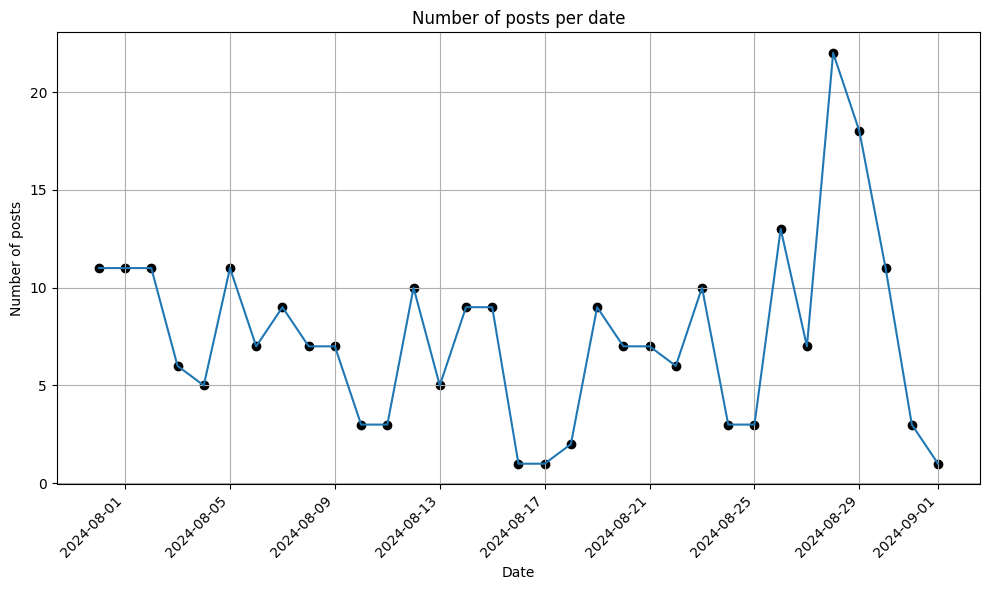

In [ ]:
import json

# Load the JSON data from the file
with open('nvidia_stock_data_2024_08_01_2024_09_02.json', 'r') as file:
    data = json.load(file)
# Find top 3 posts on August 28th
target_date = datetime.datetime(2024, 8, 28).date()
posts_on_target_date = []

for post in data['submissions']:
    post_date = datetime.datetime.fromtimestamp(post['created']).date()
    if post_date == target_date:
        posts_on_target_date.append(post)

# Sort posts by score in descending order and get top 3
top_3_posts_aug_28 = sorted(posts_on_target_date, key=lambda x: x.get('score', 0), reverse=True)[:3]

print("Top 3 posts on August 28th:")
for i, post in enumerate(top_3_posts_aug_28, 1):
    print(f"\n{i}. Score: {post.get('score', 'N/A')}")
    print(f"   Title: {post.get('title', 'N/A')[:150]}...")  # Print first 100 characters of the title
    print(f"   Author: {post.get('author', 'N/A')}")
    print(f"   Created: {datetime.datetime.fromtimestamp(post['created'])}")

# Find top 3 posts overall
all_posts = data['submissions']
top_3_posts_overall = sorted(all_posts, key=lambda x: x.get('score', 0), reverse=True)[:3]

print("\nTop 3 posts overall:")
for i, post in enumerate(top_3_posts_overall, 1):
    print(f"\n{i}. Score: {post.get('score', 'N/A')}")
    print(f"   Title: {post.get('title', 'N/A')[:150]}...")  # Print first 100 characters of the title
    print(f"   Author: {post.get('author', 'N/A')}")
    print(f"   Created: {datetime.datetime.fromtimestamp(post['created'])}")
# Create a DataFrame from the comments
df = pd.DataFrame(data['submissions'])

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['created'], unit='s')

# Group by date and count the number of posts for each date
comments_per_date = df.groupby(df['date'].dt.date).size()

# Print the number of posts for each date
print(comments_per_date)
# Plot the number of posts for each date
plt.figure(figsize=(10, 6))

comments_per_date.plot()
plt.scatter(comments_per_date.index, comments_per_date.values, color='black')
plt.xlabel('Date')
plt.ylabel('Number of posts')
plt.title('Number of posts per date')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

### print top 3 comments overall and on 28 August and plot number of comments per date

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 3 comments on August 28th:

1. Score: 275
   Author: YamahaFourFifty
   Created: 2024-08-28 20:51:58
   Text: Because everyone made stupid call options for 130+...

2. Score: 166
   Author: banditcleaner2
   Created: 2024-08-28 21:25:10
   Text: Hot take, but I believe the real reason it’s down is because the forward guidance revenue for next quarter was not astronomically higher then analyst ...

3. Score: 153
   Author: ZHPpilot
   Created: 2024-08-28 20:56:29
   Text: Because I decided to hold, if I would have sold it would be @ $140 right now....

Top 3 comments overall:

1. Score: 292
   Author: jerwang24
   Created: 2024-08-08 00:24:14
   Text: You’re being too emotional and don’t understand the company’s financials or business.  You’re just doing what everyone else is doing.  That’s why you’...

2. Score: 275
   Author: YamahaFourFifty
   Created: 2024-08-28 20:51:58
   Text: Because everyone made stupid call options for 130+...

3. Score: 258
   Author: behindcl0seddrs
   C

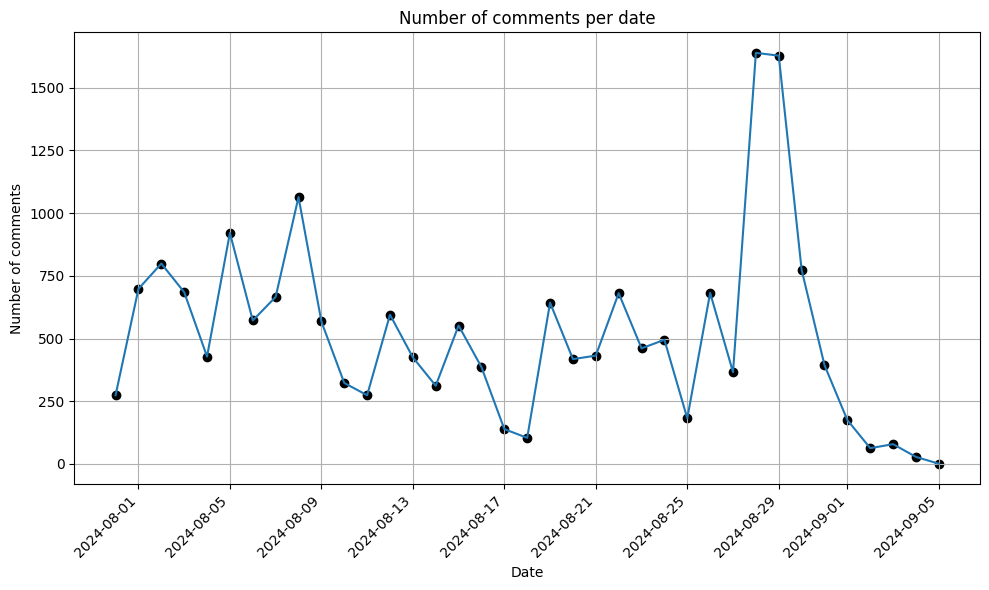

In [ ]:
# Load the JSON data from the file
with open('nvidia_stock_data_comments2024_08_01_2024_09_02.json', 'r') as file:
    data = json.load(file)
# Find top 5 comments on August 28th
target_date = datetime.datetime(2024, 8, 28).date()
comments_on_target_date = []

for comment in data['submissions']:
    comment_date = datetime.datetime.fromtimestamp(comment['created']).date()
    if comment_date == target_date:
        comments_on_target_date.append(comment)

# Sort comments by score in descending order and get top 3
top_5_comments = sorted(comments_on_target_date, key=lambda x: x.get('score', 0), reverse=True)[:3]

print("Top 3 comments on August 28th:")
for i, comment in enumerate(top_5_comments, 1):
    print(f"\n{i}. Score: {comment.get('score', 'N/A')}")
    print(f"   Author: {comment.get('author', 'N/A')}")
    print(f"   Created: {datetime.datetime.fromtimestamp(comment['created'])}")
    print(f"   Text: {comment.get('text', 'N/A')[:150]}...")  # Print first 100 characters of the comment

# Find top 3 comments overall
all_comments = data['submissions']
top_3_comments_overall = sorted(all_comments, key=lambda x: x.get('score', 0), reverse=True)[:3]

print("\nTop 3 comments overall:")
for i, comment in enumerate(top_3_comments_overall, 1):
    print(f"\n{i}. Score: {comment.get('score', 'N/A')}")
    print(f"   Author: {comment.get('author', 'N/A')}")
    print(f"   Created: {datetime.datetime.fromtimestamp(comment['created'])}")
    print(f"   Text: {comment.get('text', 'N/A')[:150]}...")  # Print first 150 characters of the comment

# Create a DataFrame from the comments
df = pd.DataFrame(data['submissions'])

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['created'], unit='s')

# Group by date and count the number of comments for each date
comments_per_date = df.groupby(df['date'].dt.date).size()

# Print the number of comments for each date
print(comments_per_date)
# Plot the number of comments for each date
plt.figure(figsize=(10, 6))

comments_per_date.plot()
plt.scatter(comments_per_date.index, comments_per_date.values, color='black')
plt.xlabel('Date')
plt.ylabel('Number of comments')
plt.title('Number of comments per date')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

# Data Preprocessing

In [ ]:
def processText(text, abbreviations, tokenizer, n_grams, lemmatizer, stopwords):
    """
    Process the text by tokenizing, lemmatizing, and removing stopwords.

    @param text: The text to process
    @param abbreviations: Dictionary of abbreviations
    @param tokenizer: Tokenizer to use
    @param n_grams: Number of n-grams
    @param lemmatizer: Lemmatizer to use
    @param stopwords: List of stopwords

    @returns: A list of processed tokens
    """
    # Remove URLs and other patterns
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Convert all tokens to lowercase
    tokens = [item.lower() for item in tokens]

    # Replace abbreviations
    tokens = [abbreviations.get(token, token) for token in tokens]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    tokens = [token for token in tokens if not token.isdigit() and token not in stopwords]

    # Generate n-grams if n_grams > 1
    if n_grams > 1:
        tokens = list(nltk.ngrams(tokens, n_grams))

    return tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Do parallel processing to speed up code and save tokens to .txt files and make term frequencies

In [ ]:
# Function to process each submission
def process_submission(submission, abbreviations, tokenizer, n_grams, lemmatizer, stopwords):
    submissionsTitle = submission.get('text', '')
    lTokens = processText(text=submissionsTitle, abbreviations=abbreviations, tokenizer=tokenizer, n_grams=n_grams, lemmatizer=lemmatizer, stopwords=stopwords)
    return lTokens

# Function to handle parallel processing
def process_submissions(submission, abbreviations, tokenizer, n_grams, lemmatizer, stopwords):
    return process_submission(submission, abbreviations, tokenizer, n_grams, lemmatizer, stopwords)

# Load JSON file
fJsonName = f"nvidia_stock_data_comments{start_date.strftime('%Y_%m_%d')}_{end_date.strftime('%Y_%m_%d')}.json"
freqNum = 100

# Tweet tokenizer to use
tweetTokeniser = nltk.tokenize.TweetTokenizer()
# Use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)
# Use stopwords from nltk and a few other Twitter-specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['via'] + ["’"] + ["..."] + ["…"]

redditLemmatizer = nltk.stem.WordNetLemmatizer()

# Our term frequency counter
termFreqCounter = Counter()
n_grams = 1

abbreviations = {}
ltokens = {}

# Check if the file exists and is not empty
if os.path.exists('abbreviations.txt') and os.path.getsize('abbreviations.txt') > 0:
    with open('abbreviations.txt') as json_file:
        abbreviations = json.load(json_file)

# Open JSON file and process it tweet by tweet using ijson for iterative parsing
with open(fJsonName, 'r') as f:
    dSubmissions = ijson.items(f, 'submissions.item')

    # Parallel processing of submissions
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_submissions, dSubmissions, repeat(abbreviations), repeat(tweetTokeniser), repeat(n_grams), repeat(redditLemmatizer), repeat(lStopwords)))
    # Determine the output file name based on fJsonName
    if "comments" in fJsonName:
        output_file_name = 'submission_tokens_comments.txt'
    else:
        output_file_name = 'submission_tokens_post.txt'

    # Update term frequency counter and save tokens to file
    with open(output_file_name, 'a') as f:
        for lTokens in results:
            f.write(' '.join(lTokens) + '\n')
            termFreqCounter.update(lTokens)

freq_terms = []
# Print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    freq_terms.append(term)
    freq_terms.append(count)
    print(term + ': ' + str(count))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ijson/compat.py:32: DeprecationWarning: 
ijson works by reading bytes, but a string reader has been given instead. This
probably, but not necessarily, means a file-like object has been opened in text
mode ('t') rather than binary mode ('b').

An automatic conversion is being performed on the fly to continue, but on the
other hand this creates unnecessary encoding/decoding operations that decrease
the efficiency of the system. In the future this automatic conversion will be
removed, and users will receive errors instead of this warning. To avoid this
problem make sure file-like objects are opened in

nvidia: 4251
dollar: 3467
stock: 2894
wa: 2333
market: 2116
year: 2064
like: 1954
earnings: 1703
buy: 1697
think: 1544
share: 1544
go: 1499
time: 1491
company: 1419
would: 1406
price: 1331
going: 1330
people: 1325
good: 1286
ha: 1275
money: 1238
ai: 1202
one: 1201
get: 1186
back: 1080
sell: 1069
day: 1067
make: 1049
see: 1049
know: 1044
long: 1033
even: 1020
i'm: 919
call: 917
right: 890
also: 877
bought: 877
month: 872
still: 867
laughing out loud: 853
much: 840
next: 819
week: 775
way: 759
term: 757
thing: 748
could: 744
well: 716
option: 693
say: 685
hold: 669
lot: 668
need: 640
last: 636
buying: 633
put: 628
want: 624
really: 620
point: 599
big: 597
look: 592
today: 592
take: 584
said: 572
that's: 567
dip: 552
blackwell: 541
profit: 535
mean: 532
got: 518
growth: 512
keep: 507
chip: 503
high: 503
investor: 498
“: 495
post: 492
sure: 486
..: 485
yes: 482
drop: 476
”: 469
better: 469
short: 467
selling: 461
already: 458
revenue: 458
around: 455
many: 454
news: 451
always: 450
sold: 4

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


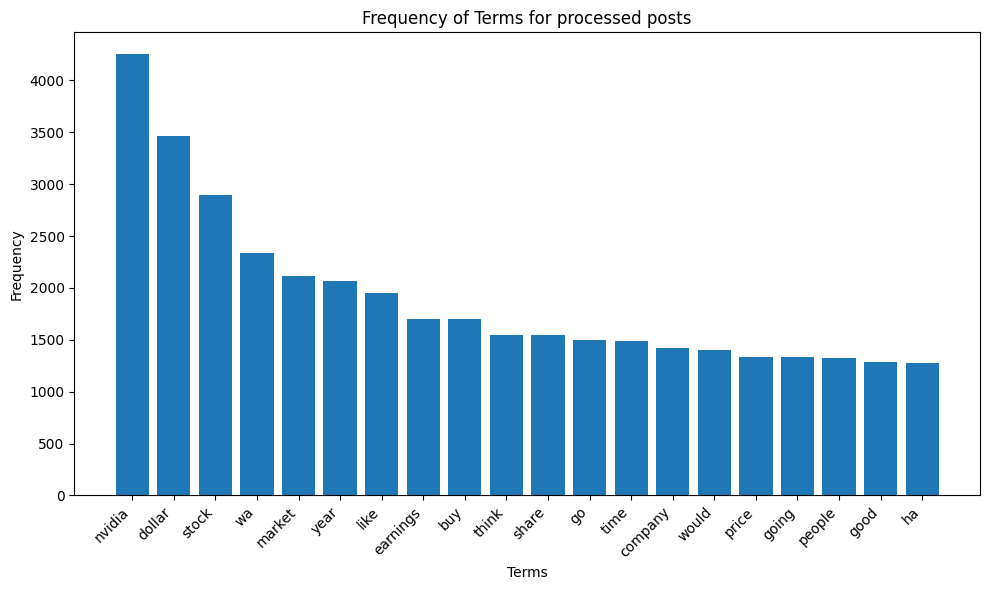

In [ ]:
def plot_term_frequencies(freq_terms, top_n=20, title='Frequency of Terms'):
    """
    Plots the frequency of terms.

    Parameters:
    freq_terms (list): A list of terms and their frequencies in alternating order.
    top_n (int): The number of top terms to display in the plot. Default is 20.
    title (str): The title of the plot.
    """
    labels = []
    values = []

    # Iterate through the list
    for i in range(0, len(freq_terms), 2):
        labels.append(freq_terms[i])      # Add the string to labels list
        values.append(freq_terms[i+1])    # Add the number to values list

    plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
    plt.bar(labels[:top_n], values[:top_n])

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Add title and labels
    plt.title(title)
    plt.xlabel('Terms')
    plt.ylabel('Frequency')

    # Adjust layout to ensure everything fits
    plt.tight_layout()

    # Display the plot
    plt.show()
    #     # Join the different processed titles together.
plot_term_frequencies(freq_terms, top_n=20, title='Frequency of Terms for processed posts')

### Function to determine term frequency of raw data

In [ ]:
def onlyprocessText(text):
    # tweet tokeniser to use
    tweetTokeniser = nltk.tokenize.TweetTokenizer()
    lTokens = tweetTokeniser.tokenize(text)
    return lTokens

# Function to process each submission
def process_submission(submission):
    submissionsTitle = submission.get('text', '') or submission.get('title', '')
    lTokens = onlyprocessText(text=submissionsTitle)
    return lTokens


# Function to handle parallel processing
def process_submissions(submission):
    return process_submission(submission)

# Our term frequency counter
termFreqCounter = Counter()

# Open JSON file and process it tweet by tweet using ijson for iterative parsing
with open(fJsonName, 'r') as f:
    dSubmissions = ijson.items(f, 'submissions.item')

    # Parallel processing of submissions
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_submissions, dSubmissions))

    # Update term frequency counter and save tokens to file
    with open('submission_tokens_raw.txt', 'a') as f:
        for lTokens in results:
            f.write(' '.join(lTokens) + '\n')
            termFreqCounter.update(lTokens)

freq_terms = []
# Print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    freq_terms.append(term)
    freq_terms.append(count)
    print(term + ': ' + str(count))

plot_term_frequencies(freq_terms, top_n=20, title='Frequency of Terms for raw comments')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ijson/compat.py:32: DeprecationWarning: 
ijson works by reading bytes, but a string reader has been given instead. This
probably, but not necessarily, means a file-like object has been opened in text
mode ('t') rather than binary mode ('b').

An automatic conversion is being performed on the fly to continue, but on the
other hand this creates unnecessary encoding/decoding operations that decrease
the efficiency of the system. In the future this automatic conversion will be
removed, and users will receive errors instead of this warning. To avoid this
problem make sure file-like objects are opened in

### combine posts and comment tokens to one list

In [ ]:
# Read the contents of submission_tokens.txt and convert it to a list where each line is an element of the list as a string

with open('submission_tokens_posts.txt', 'r') as file:
    lPost = file.read().splitlines()
with open('submission_tokens_comments.txt', 'r') as file:
    lPosts_comments = file.read().splitlines()
lPosts = lPost + lPosts_comments
# Print the list to verify
print(lPosts)

['people group', 'ai future', '108', 'gonna long night', 'pelosi pump', 'stock pull-back bit expected', 'nvidia still going 150 january', 'nvidia hit 10 trillion market cap', '', 'holy', 'please calm case last 5 quarter', 'nvidia sell-off coming short-lived', 'nasdaq 100 nvidia earnings', 'literally money nvidia', '2.5 dollar nvidia share ama', 'nvidia hit 200 2025', 'market rally begun', 'hell yeah brother', 'rant actual shareholder', 'thank guy', 'psa newcomer', '8/ 30 option expired worthless', 'bringing belt back', 'nvidia beat everything going', 'jensen joining bloomberg interview tomorrow post earnings would ceo', "bloomberg let's nvidia bear spew nonsense 20 minute jensen's first response blackwell delay", 'lower nvidia average', 'back', 'safe say 130 call option toast', 'real one', 'bofa name nvidia top rebound stock 2024 chip comeback', 'bought nvidia', 'nvidia gpu shipment expected rise 50 also increasing asp stock trading 40x next year earnings growing well 50', 'load', 'nvi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA Model

### Plotting coherence term plot to determine optimal number of topics

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np

# Read and combine the data (this part remains the same)
with open('submission_tokens_posts.txt', 'r') as file:
    lPost = file.read().splitlines()
with open('submission_tokens_comments.txt', 'r') as file:
    lPosts_comments = file.read().splitlines()

lPosts = lPost + lPosts_comments
data = [post.split() for post in lPosts]

# Create Dictionary and Corpus (this part remains the same)
id2word = corpora.Dictionary(data)
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

def compute_coherence_for_model(params):
    """Compute coherence for a single model"""
    num_topics, dictionary, corpus, texts = params
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """Compute coherence values for multiple models in parallel"""
    pool = Pool(processes=cpu_count())
    coherence_values = pool.map(
        compute_coherence_for_model,
        [(num_topics, dictionary, corpus, texts) for num_topics in range(start, limit, step)]
    )
    pool.close()
    pool.join()
    return coherence_values

# Set parameters
start, limit, step = 2, 40, 6

# Compute coherence values
coherence_values = compute_coherence_values(id2word, corpus, texts, start, limit, step)

# Plot results
x = range(start, limit, step)
plt.figure(figsize=(12, 6))
plt.plot(x, coherence_values, 'bo-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Topic Coherence Scores by Number of Topics")
plt.grid(True)
plt.tight_layout()
plt.show()

# Find optimal number of topics
optimal_num_topics = x[np.argmax(coherence_values)]
print(f'Optimal number of topics: {optimal_num_topics}')

In [ ]:
# number of topics to discover (default = 10)
topicNum = 2
# maximum number of words to display per topic (default = 10)
# Answer to Exercise 1 (change from 10 to 15)
wordNumToDisplay = 5
# this is the number of features/words to used to describe our documents
# please feel free to change to see effect
featureNum = 1500

Performs counting via CountVectorizer and then apply the LDA model.

In [ ]:
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lPosts)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

### Visualising topics

In [ ]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

Diplays discovered topics.

In [ ]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

### pyLDAvis

In [ ]:
# TODO: Add the pyLDAvis code here
# note if you also implemented the word cloud, that will display first, then once you close that
# file, then this will display
# Answer to exercise 2
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

### Wordcloud

In [ ]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    # TODO: complete the implementation

    #
    # Answer to Exercises 3 and 4
    #

    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

def displayWordcloud(lda_model, tf_feature_names, num_words=10, output_dir='wordclouds'):
    """
    Display and save word clouds for each topic in the LDA model.

    @param lda_model: Trained LDA model
    @param tf_feature_names: List of feature names (terms)
    @param num_words: Number of words to display in the word cloud
    @param output_dir: Directory to save the word cloud images
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for topic_idx, topic in enumerate(lda_model.components_):
        # Generate word cloud
        wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=num_words)
        wordcloud.generate_from_frequencies(dict(zip(tf_feature_names, topic)))

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic #{topic_idx}')
        plt.show()

        # Save the word cloud image
        wordcloud.to_file(os.path.join(output_dir, f'topic_{topic_idx}.png'))

# Example usage
# Assuming lda_model and tf_feature_names are already defined
displayWordcloud(ldaModel, tfFeatureNames)

In [ ]:
# display wordcloud
# TODO: go to the function definition and complete its implementation
displayWordcloud(ldaModel, tfFeatureNames)

# Sentiment Analysis

## Use count method to calculate the sentiment

In [ ]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    """
    Compute the overall sentiment of the list of tokens in lTokens, using the countWordSentimentAnalysis approach.

    @param lTokens: List of tokens to calculate the overall sentiment for.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.

    @returns Sentiment score for lTokens.
    """


    posNum = len([tok for tok in lTokens if tok in setPosWords])

    negNum = len([tok for tok in lTokens if tok in setNegWords])
    sentiment = posNum - negNum
    return sentiment


In [ ]:
def printColouredTokens(lTokens, setPosWords, setNegWords, sentiment):
    """
    Print out the tokens in different colours, according to sentiment.
    If positive, in red.
    If negative, in blue.
    Otherwise no colouring.

    @param lTokens: List of tokens to print and colour.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.
    @param sentiment: Sentiment score of list of tokens.
    """

    for token in lTokens:
        if token in setPosWords:
            print(Fore.RED + token + ', ', end='')
        elif token in setNegWords:
            print(Fore.BLUE + token + ', ', end='')
        else:
            print(Style.RESET_ALL + token + ', ', end='')

    print(': {}'.format(sentiment))


In [ ]:
def countWordSentimentAnalysis(setPosWords, setNegWords, sTweetsFilename, bPrint):
    """
    Basic sentiment analysis.  Count the number of positive words, count the negative words, overall polarity is the
    difference in the two numbers.

    @param setPosWords: set of positive sentiment words
    @param setNegWords: set of negative sentiment words
    @param sFilename: name of input file containing a json formated dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param redditProcessor: RedditProcessing object, used to pre-process each tweet.

    @returns: list of reddit posts, in the format of [date, sentiment]
    """


    lSentiment = []
    # open file and process reddit submissions and comments, one by one
    with open(sTweetsFilename, 'r') as f:
        redditDump = json.load(f)

        for submission in redditDump['submissions']:
              if "comments" in fJsonName:
                postText = submission["text"]
              else:
                postText = submission['title']

              postDate = submission['created']

              # tokenise, filter stopwords and get convert to lower case
              lTokens = processText(text=postText, abbreviations = abbreviations, tokenizer=tweetTokeniser, n_grams=n_grams, lemmatizer=redditLemmatizer, stopwords=lStopwords)

              # from where this redditProcessor comes from?

              # compute sentiment
              sentiment = computeSentiment(lTokens, setPosWords, setNegWords)

              # save the date and sentiment of each reddit post (used for time series)
              lSentiment.append([pd.to_datetime(postDate, unit='s'), sentiment])

              # if we are printing, each token is printed and coloured according to red if positive word, and blue
              # if negative
              if bPrint:
                  printColouredTokens(lTokens, setPosWords, setNegWords, sentiment)
    return lSentiment


### Approach 2: Vader based approach to sentiment analysis.

In [ ]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.

    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [ ]:
def vaderSentimentAnalysis(sTweetsFilename, bPrint):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    # open file and process tweets, one by one
    with open(sTweetsFilename, 'r') as f:
        redditDump = json.load(f)

        for submission in redditDump['submissions']:
              if "comments" in fJsonName:
                postText = submission["text"]
              else:
                postText = submission['title']
              postDate = submission['created']

              # tokenise, filter stopwords and get convert to lower case
              lTokens = processText(text=postText, abbreviations = abbreviations, tokenizer=tweetTokeniser, n_grams=n_grams, lemmatizer=redditLemmatizer, stopwords=lStopwords)


              # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
              # see workshop sheet for what dSentimentScores holds
              dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

              # save the date and sentiment of each post (used for time series)
              lSentiment.append([pd.to_datetime(postDate, unit='s'), dSentimentScores['compound']])

              # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
              # of positive and negative words, we cannot use colorama to label each token
              if bPrint:
                  vaderPrintTokens(lTokens, dSentimentScores)

    return lSentiment

In [ ]:
# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'
# input file of set of reddit posts (json format)
# redditFile = 'nvidia_stock_data_1_11_2015_13_8_2024.json'
# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# specify the approach to take, one of [count, vader]
# change this to use a different sentiment approach
approach = 'count'

In [ ]:

# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [ ]:
# compute the sentiment
# to change method, update parameter settings, particularly the variable 'approach' and rerun the parameter setting cell,
# and also this cell
lSentiment = []
if approach == 'count':
    lSentiment = countWordSentimentAnalysis(setPosWords, setNegWords, fJsonName, flagPrint)
elif approach == 'vader':
    lSentiment = vaderSentimentAnalysis(fJsonName, flagPrint)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
generate, code, text, input, using, llm, mechanic, need, expert, coding, : 0
took, period, 3-7, million, year, human, brain, evolve, homo, sapiens, appeared, 200,000, year, ago, brain, mass, increased, approximately, 1.3, kg, human, brain, doe, doe, enables, human, thing, including, innovation, manipulation, due, structural, mechanical, system, human, body, nothing, like, clumsy, thing, computer, scientist, today, even, clue, make, real, humanoid, made, already, like, year, ago, honestly, company, milking, people, money, lofty, idea, promise, produce, roi, half, century, also, whole, moore's, law, thing, fundamental, limit, chip, size, thermodynamic, limit, way, robot, anything, close, human, possibly, forever, .., : 0
would, know, wrong, software, fix, : -1
yeah, point, °, technology, exponential, compare, time, took, humanity, create, first, plane, v, time, period, going, moon, good, example, °, ai, concept, self, learning, league, h

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


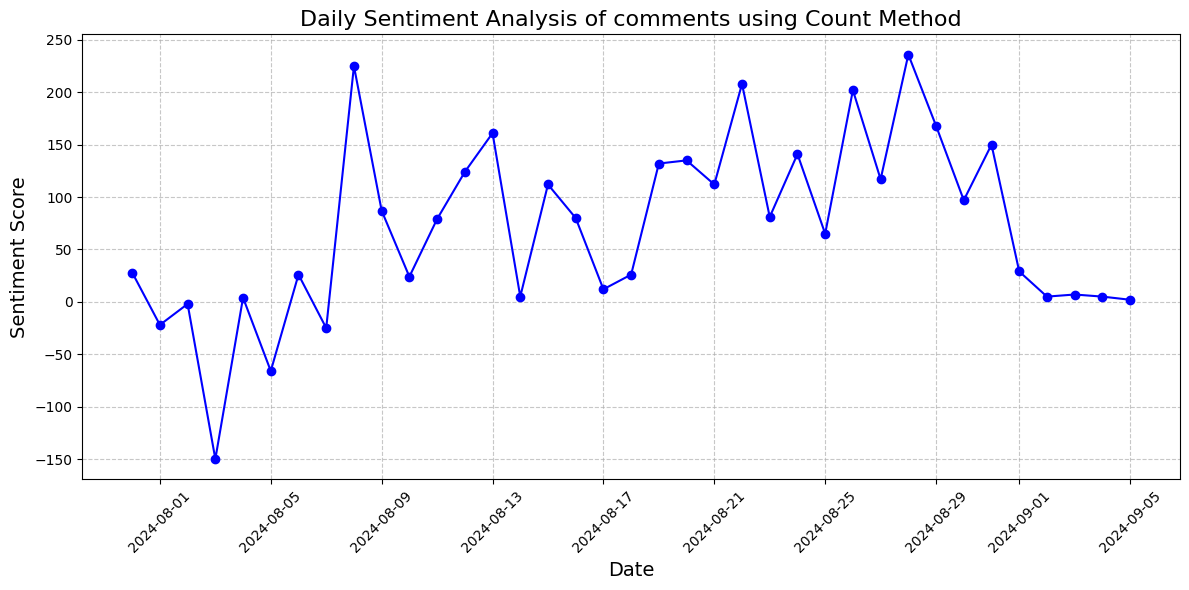

In [ ]:

# we are using pandas for this, but first we need to get it into a pandas data frame structure
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])
# tell pandas that the date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)
# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

newSeries = series.resample('1D').sum()
# this plots and shows the time series
# Plot the time series with enhanced appearance
plt.figure(figsize=(12, 6))
plt.plot(newSeries, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Daily Sentiment Analysis of comments using Count Method', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()